# Project 1

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv) is adapted from the World Health Organization on Strokes (it's based on real data but is NOT REAL). Use this dataset to answer the following questions and perform the following tasks. Feel free to add extra cells as needed, but <strong>clearly identify where each question is answered, both the code and Markdown cells</strong>. Please remove any superflous code. Please put any written/typed responses in MARKDOWN CELLS.

## Data Information

- `reg_to_vote`: 0 if no, 1 if yes.
- `age`: age of the patient in years.
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
- `ever_married`: 0 if no, 1 if yes.
- `Residence_type`: 0 for Rural, 1 for Urban.
- `avg_glucose_level`: average glucose level in blood.
- `bmi`: body mass index.
- `smoking_status_smokes`, `smoking_status_formerly`: Whether or not the person smokes, or formerly smoked. If a person has 0's for both these columns, they never smoked.
- `stroke`: 1 if the patient had a stroke or 0 if not.
- `dog_owner`: 0 if no, 1 if yes.
- `er_visits`: number of recorded Emergency Room visits in lifetime.
- `raccoons_to_fight`: number of racoons the patient belives they could fight off at once.
- `fast_food_budget_month`: amount (in US dollars) spent on fast food per month.


## Part I: Logistic Regression
Build a logistic regression model to predict whether or not someone had a `stroke` based on **all** the other variables in the dataset.

1. Count the missing data per column, and remove rows with missing data (if any).
2. Use 10 fold cross validation for your model validation. Z-score your continuous/interval variables only. Store both the train and test accuracies to check for overfitting. **Is the model overfit? How can you tell?**
3. After completing steps 1-2, fit another logistic regression model on ALL of the data (no model validation; but do z score) using the same predictors as before, and put the coefficients into a dataframe called `coef`.
4. print out a confusion matrix for the model you made in part 3. **What does this confusion matrix tell you about your model? How can you tell?**

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph per question** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. In this specific data set, do dog-owners over 50 have a higher average probability of stoke than non-dog owners who currently smoke? How can you tell? (Do not use the model for this question, it's asking you to compare the observed probability of having a stroke in the two groups described).
2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?
3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 90k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy for each of these groups; DO NOT create/fit new models for each income range, use the model from part I-3 to calculate the accuracy for each of these groups.)
4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?
5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

In [171]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics


%matplotlib inline

In [172]:
strokes = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv")

strokes.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_smokes,smoking_status_formerly,reg_to_vote,dog_owner,raccoons_to_fight,fast_food_budget_month,income_in_k,er_visits
0,60.0,1.0,0.0,0.0,1.0,73.00,25.2,0,1,0,1.0,1.0,10.0,209.19,51.553645,9.0
1,4.0,0.0,0.0,0.0,0.0,110.15,17.1,0,0,0,0.0,1.0,13.0,176.46,45.405414,5.0
2,77.0,0.0,0.0,1.0,1.0,68.38,27.8,0,0,0,0.0,1.0,6.0,213.00,94.865174,8.0
3,37.0,0.0,0.0,1.0,1.0,95.08,30.1,0,0,0,1.0,1.0,12.0,161.90,84.123775,8.0
4,44.0,0.0,0.0,0.0,0.0,103.78,40.9,0,1,0,1.0,1.0,11.0,261.29,74.794596,11.0


# Part 1:

## 1.

In [173]:
nullHyper = strokes["hypertension"].isnull()

nullHyper.sum()

nullCols = strokes.isnull().sum()
nullCols

age                         13
hypertension                12
heart_disease               21
ever_married                 9
Residence_type              21
avg_glucose_level           31
bmi                        575
stroke                       0
smoking_status_smokes        0
smoking_status_formerly      0
reg_to_vote                 14
dog_owner                   21
raccoons_to_fight           27
fast_food_budget_month       8
income_in_k                 21
er_visits                   15
dtype: int64

In [174]:
strokes = strokes.dropna()
strokes.head()
strokes.shape

(14222, 16)

## 2.

In [175]:
# Kfold

predictors = ["age","hypertension","heart_disease","ever_married",
             "Residence_type","avg_glucose_level","bmi",
             "smoking_status_smokes","smoking_status_formerly",
             "reg_to_vote","dog_owner","raccoons_to_fight",
             "fast_food_budget_month","income_in_k","er_visits"]

contin = ["age","avg_glucose_level","bmi","er_visits","raccoons_to_fight","fast_food_budget_month","income_in_k"]

X = strokes[["age","hypertension","heart_disease","ever_married",
             "Residence_type","avg_glucose_level","bmi",
             "smoking_status_smokes","smoking_status_formerly",
             "reg_to_vote","dog_owner","raccoons_to_fight",
             "fast_food_budget_month","income_in_k","er_visits"]]

y = strokes["stroke"]

# create k-fold object
kf = KFold(n_splits = 10)
kf.split(X)

lr = LogisticRegression() #create model

acctrain = [] #create empty list to store accuracy for each fold
acctest = []

 #Use a for loop to loop through each fold and train a model, then add the accuracy to acc.

for train_indices, test_indices in kf.split(X):
    # Get your train/test for this fold
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test  = y.iloc[test_indices]
    
    # z score
    z = StandardScaler()
    X_train = z.fit_transform(X_train[contin])
    X_test  = z.transform(X_test[contin])


    
    # model
    model = lr.fit(X_train, y_train)
    # record accuracy
    acctest.append(accuracy_score(y_test, model.predict(X_test)))
    acctrain.append(accuracy_score(y_train, model.predict(X_train)))
    
#print overall acc
testmean = np.mean(acctest)
trainmean = np.mean(acctrain)
print("Test data mean accuracy: " + str(testmean))
print("Train data mean accuracy: " + str(trainmean))

Test data mean accuracy: 0.960343680720492
Train data mean accuracy: 0.9603509496591529


The data does not seem to be overfit. This is because there is no significant disparity between the model effectiveness on the test and data set. The model is very slightly more accurate at predicting the training data, however it is not a significant amount to consider the data to be overfit.

## 3.

In [176]:

Xlog = strokes[predictors]

zscore = StandardScaler()

zscore.fit_transform(Xlog[contin])


model = LogisticRegression()
model.fit(Xlog,y)

coef = pd.DataFrame({"Coef": model.coef_[0], "Names": predictors})
coef = coef.append({"Coef": model.intercept_[0],
                    "Names": "intercept"}, ignore_index = True)
coef


,Coef,Names
0,0.046187,age
1,0.506969,hypertension
2,0.547719,heart_disease
3,-0.384674,ever_married
4,-0.357392,Residence_type
5,0.004104,avg_glucose_level
6,-0.086468,bmi
7,0.120141,smoking_status_smokes
8,0.102136,smoking_status_formerly
9,-0.501384,reg_to_vote


## 4.

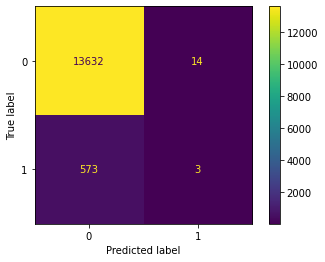

In [177]:
plot_confusion_matrix(model, Xlog, y)
plt.show()

This confusion matrix plot shows that this model is extremely effective at predicting correctly that an individual has not had a stroke. This is because 13,632 data points were accurately predicted from the the predicting data using the model. This box in the top left shows when the model predicted no stroke for the individual, and the actual data is that the individual didn't have a stroke. However, it is very rare for the model to predict that an individual has had a stroke. This is apparent in the box on the bottom right. This box shows when the model predicts and individual has had a stroke, and the actual data shows that they have indeed had a stroke. So the model appears to pretty accurately predict that an individual has not had a stroke, but hardly every predicts that an individual has had a stroke.

# Part 2

## 1

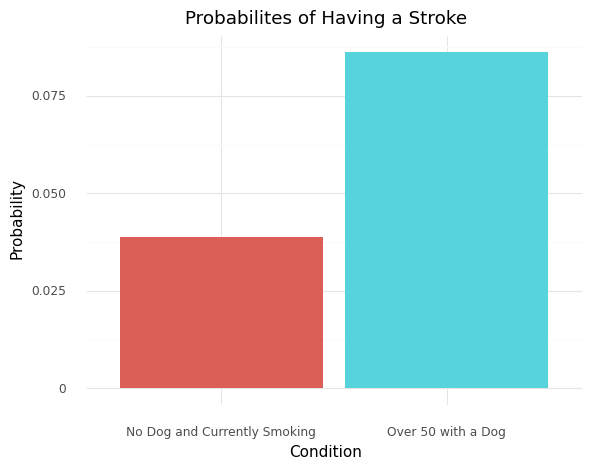

<ggplot: (8741375090149)>

In [178]:
dog50 = (strokes["age"] > 50) & (strokes["dog_owner"] == 1)
dog50stroke = (strokes["age"] > 50) & (strokes["dog_owner"] == 1) & (strokes["stroke"] == 1)

nodogsmoke = (strokes["dog_owner"] == 0) & (strokes["smoking_status_smokes"] == 1)
nodogsmokestroke = (strokes["dog_owner"] == 0) & (strokes["smoking_status_smokes"] == 1) & (strokes["stroke"] == 1)

total = strokes.shape[0]

toDF = [["Over 50 with a Dog", dog50stroke.sum() / dog50.sum()], ["No Dog and Currently Smoking", nodogsmokestroke.sum() / nodogsmoke.sum()]]

probs = pd.DataFrame(toDF, columns = ["Condition", "Probability"])

probs

(ggplot(probs, aes(x = "Condition", y = "Probability", fill = "Condition")) + geom_bar(stat = "identity") + theme_minimal() + ggtitle("Probabilites of Having a Stroke") + theme(legend_position = "none"))

As you can see on the graph, individuals that are over 50 years old and have a dog are about twice as likely to have a stroke. Individuals without a dog and are currently smoking are much less likely to have a stroke compared to the other group.

## 2

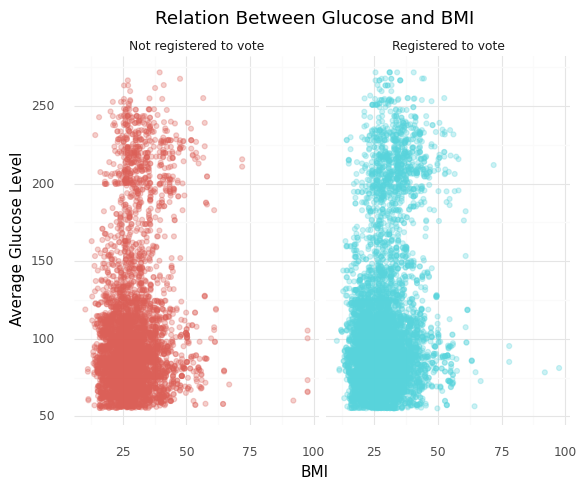

<ggplot: (8741377969549)>

In [179]:

sub = strokes[["bmi", "avg_glucose_level", "reg_to_vote"]]

sub.loc[sub.reg_to_vote == 0.0, "reg_to_vote"] = "Not registered to vote"
sub.loc[sub.reg_to_vote == 1.0, "reg_to_vote"] = "Registered to vote"



(ggplot(sub, aes(x = "bmi", y = "avg_glucose_level", color = "reg_to_vote")) + geom_point(alpha= 0.3) + facet_wrap("reg_to_vote") + theme_minimal() + theme(legend_position = "none") + xlab("BMI") + ylab("Average Glucose Level") + ggtitle("Relation Between Glucose and BMI"))

Based on this graph, it would appear that there could possibly be a relation between the BMI of and individual and their average glucose levels. However, there is no strong indication of a relationship. As BMI increases it seems that average glucose levels have a very slightly higher value. This can be seen on the graph as most of the higher end glucose level data points appear when BMI is on the higher end. There is also no indication of being registered to vote having an influence on the relation between these variables whatsoever. This can be seen as the graph on the left and the graph on the right appear to have the same shape and there is no apparent difference between the relation between the variables in each graph.

## 3

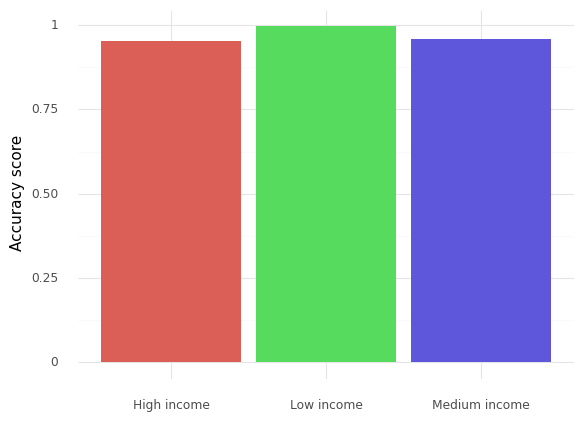

<ggplot: (8741376279657)>

In [180]:
low = (strokes.loc[strokes["income_in_k"] < 30])
medium = (strokes.loc[(strokes["income_in_k"] >= 30) & (strokes["income_in_k"] <= 90)])
high = (strokes.loc[strokes["income_in_k"] > 90])

lowX = low[predictors]
lowacc = accuracy_score(low["stroke"], model.predict(lowX))

medX = medium[predictors]
medacc = accuracy_score(medium["stroke"], model.predict(medX))

highX = high[predictors]
highacc = accuracy_score(high["stroke"], model.predict(highX))

toDFincome = [["Low income", lowacc], ["Medium income", medacc], ["High income", highacc]]
income = pd.DataFrame(toDFincome, columns = ["Income", "Accuracy score"])


(ggplot(income, aes(x = "Income", y = "Accuracy score", fill = "Income", label = "Accuracy score")) + geom_bar(stat = "identity")  + theme_minimal() + xlab("") + theme(legend_position = "none"))

In [181]:
print("Low income accuracy: " + str(lowacc))
print("Medium income accuracy: " + str(medacc))
print("High income accuracy: " + str(highacc))

Low income accuracy: 0.9957805907172996
Medium income accuracy: 0.9596970516635109
High income accuracy: 0.951969592259848


This graph shows how accurate the model is at predicting the chances of an individual at getting a stroke in different income ranges. The data shows that the model is most accurate for individuals in the low income bracket. It has nearly the same accuracy for the medium and high income brackets, however it is slightly better at predicting in the medium income bracket. This means that the more income an individual has, the less accurate the model becomes. This could potentially be due to there simply being less data in the higher income brackets for the model to fit to.

Now, this brings some ethical dilemmas with the use of this model. This could potentially lead to more deaths and medical complications in the population of people with higher income. If the model can't accurately predict for those with higher income, it may predict that an individual is not at risk of a stroke, when they are in fact actually at risk for one. This could cause them to not get the treatment they need and begin to have medical complications from an unpredicted stroke. This could lead to a socioeconomic divide as people in higher income brackets are disproportionately affected by this model.

## 4

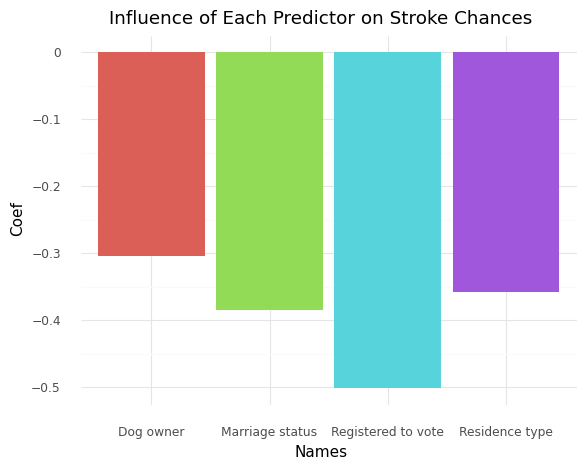

<ggplot: (8741375967777)>

In [182]:
#owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?

coef
newcoef = coef.iloc[9:11]
newcoef = newcoef.append(coef.iloc[3:5])


newcoef.loc[newcoef.Names == "reg_to_vote", "Names"] = "Registered to vote"
newcoef.loc[newcoef.Names == "dog_owner", "Names"] = "Dog owner"
newcoef.loc[newcoef.Names == "ever_married", "Names"] = "Marriage status"
newcoef.loc[newcoef.Names == "Residence_type", "Names"] = "Residence type"

newcoef["Names"]
newcoef

(ggplot(newcoef, aes(x = "Names", y = "Coef", fill = "Names")) + geom_bar(stat = "identity") + theme_minimal() + ggtitle("Influence of Each Predictor on Stroke Chances") + theme(legend_position = "none"))

Of the predictors presented, it would appear that voting registration status has the largest impact on predicting a stroke in this model. Each of these coefficients are a certain value that represents how much that condition affects the likelihood of having a stroke. The further away from 0 the coefficient is, the larger the impact it has on the output. The condition of being registered to vote has the coefficient that is the furthest from 0 out of all those presented. This means it has the biggest impact on the prediction in the model.

## 5

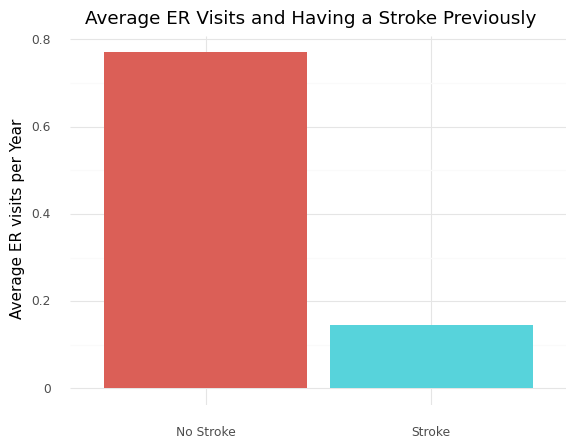

<ggplot: (8741377974941)>

In [183]:
strokeser = strokes
strokeser["er_visits_per_year"] = strokeser["er_visits"] / strokeser["age"]


#strokeser.loc["stroke"] == 1
strokesonly = strokeser.loc[(strokeser["stroke"] == 1)]
nostrokes = strokeser.loc[(strokeser["stroke"] == 0)]

nostrokeavg = nostrokes["er_visits_per_year"].mean()
strokeavg = strokesonly["er_visits_per_year"].mean()

toDFer = [["Stroke", strokeavg ], ["No Stroke", nostrokeavg]]
ervisits = pd.DataFrame(toDFer, columns = ["Stroke", "Average ER visits per Year"])

(ggplot(ervisits, aes(x = "Stroke", y = "Average ER visits per Year", fill = "Stroke")) + geom_bar(stat = "identity") + theme_minimal() + theme(legend_position = "none") + xlab("") + ggtitle("Average ER Visits and Having a Stroke Previously"))

This graph displays the difference in how many visits to the ER people have on average if they have had a stroke and if they haven't. The bar on the left shows that those that haven't had a stroke have about 0.8 ER visits on average per year. The bar on the right shows a different story. It shows that individuals that have had a stroke onlt visit the ER 0.17 times a year on average. This would indicate that those that have had a stroke on average don't go to the ER as often as individuals that haven't had a stroke.